In [3]:
############################
### import modules

import sys
import uproot
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
import csv
import io
import matplotlib.colors as colors
from scipy.optimize import curve_fit
from scipy.stats import pearsonr
import astropy
from astropy import stats
from scipy import interpolate
import os

###########################

np.set_printoptions(suppress=True)
os.chdir("../data")  # moves working directory to data folder

In [20]:
############################
### user inputs 

SSMfluxB8 = 5.46e6 #/ cm^2 s  SSM variant: B16-GS98, uncer = 12%
# add SNO B8 flux measurement

inEres = 0.15 # assumed percentage energy resolution at 1 MeV
cserr = 0.1 # percentage cross section error

Smd12 = 5.13e-5 # global solar mass-squared diff
Rmd12 = 7.42e-5 # reactor " "


#############################

numflux = SSMfluxB8  

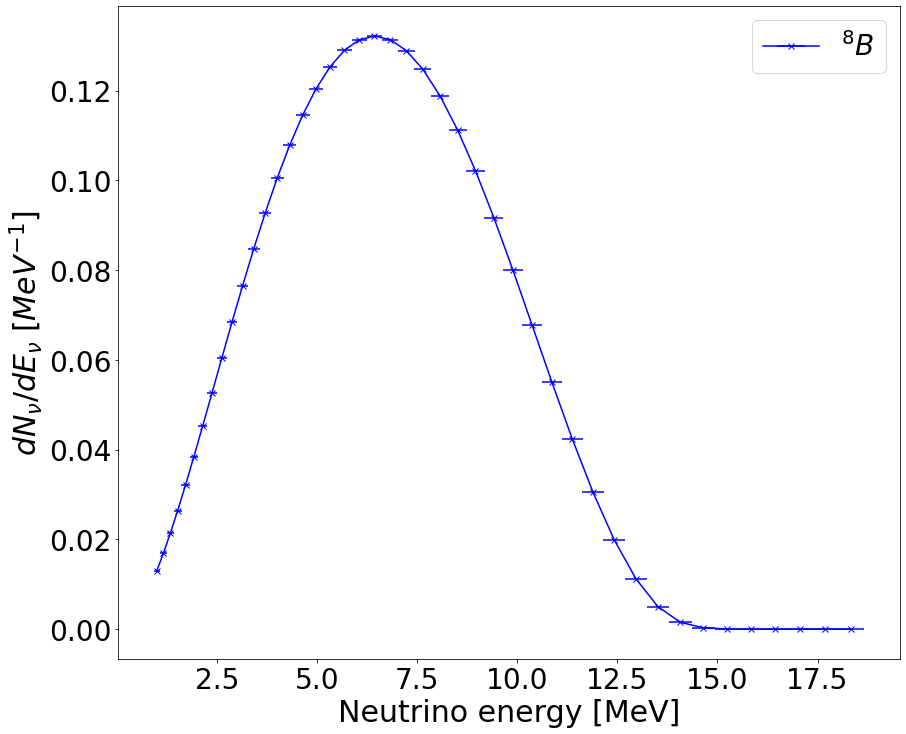

Energy: array([ 1.        ,  1.16216216,  1.3359588 ,  1.52136497,  1.71835876,
        1.92692075,  2.14703366,  2.37868194,  2.62185162,  2.87653001,
        3.14270555,  3.42036769,  3.70950674,  4.01011377,  4.32218054,
        4.64569939,  4.98066323,  5.32706544,  5.68489983,  6.05416062,
        6.43484238,  6.82694   ,  7.23044867,  7.64536386,  8.07168129,
        8.50939689,  8.95850683,  9.41900744,  9.89089528, 10.37416702,
       10.86881953, 11.37484981, 11.892255  , 12.42103234, 12.96117923,
       13.51269314, 14.07557169, 14.64981254, 15.23541349, 15.83237241,
       16.44068724, 17.06035602, 17.69137683, 18.33374785])
Flux spectrum: array([0.0130196 , 0.01686325, 0.02133887, 0.0264427 , 0.03216861,
       0.03847747, 0.04532911, 0.05265542, 0.06037449, 0.06838046,
       0.07655913, 0.0847615 , 0.09283745, 0.10062471, 0.10794962,
       0.11462969, 0.12048889, 0.12533928, 0.12901009, 0.13133332,
       0.13217095, 0.13140534, 0.12895508, 0.12477494, 0.11886679,
      

In [22]:
### imports energy spectrum shape

EvB8 = np.array([])
EvdataB8 = np.array([])
with open('bahcallB8spectrum.csv', 'r') as file: # should add commas to this file
    reader = csv.reader(file)
    for row in reader:
        temp = row[0].split()
        EvB8 = np.append(EvB8, float(temp[0])) # energy values
        EvdataB8 = np.append(EvdataB8, float(temp[1])) # normalisation units
        
### plot energy spectrum 

def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

poptB8, pcovB8 = curve_fit(gaus, EvB8, EvdataB8)

###############################

### variable bin widths based on energy resolution

x = 1 # corresponds to 1 MeV
sigmawidth = 0.5 # corresponds to a bin width of 1 sigma, controls bin purity

points = np.array([x])
uncer = np.array([inEres*sigmawidth*x])
edges = np.array([x - inEres*sigmawidth*x, x + inEres*sigmawidth*x])

while x < 18:
    Eres = inEres/x**0.5 # adds energy dependence
    xtemp = x*((1+sigmawidth*Eres)/(1-sigmawidth*Eres)) # relation to the next data point
    uncertemp = Eres*sigmawidth*xtemp
    
    uncer = np.append(uncer, uncertemp)
    points = np.append(points, xtemp)
    edges = np.append(edges, xtemp+ Eres*sigmawidth*xtemp)
    
    x = xtemp

xdata = points
bwidth = 2*uncer

###############################

tckB8 = interpolate.splrep(EvB8, EvdataB8)
yB8 = interpolate.splev(xdata, tckB8, der=0)

yB8[yB8 < 0] = 0 # removes negative values
fluxspec = yB8 

plt.figure(figsize=(14,12))

plt.errorbar(xdata, yB8, xerr=uncer, marker="x", color="blue", label=r'${}^{8}B$') # add yerrs from csv file

plt.xlabel('Neutrino energy [MeV]',fontsize=30)
plt.ylabel(r'$d N_{\nu}/d E_{\nu}$ [$MeV^{-1}$]',fontsize=30)
plt.xticks(fontsize=28)

plt.yticks(fontsize=28)
#plt.yscale('log')

plt.legend(fontsize=28)

plt.show()

print('Energy:', repr(xdata[0:len(fluxspec)]))
print('Flux spectrum:', repr(fluxspec))
print('Peak energy:', xdata[fluxspec == np.max(fluxspec)])
print('Normalisation:', np.sum(yB8*bwidth))
print('Data points:', xdata)
print('Bin widths:', bwidth)

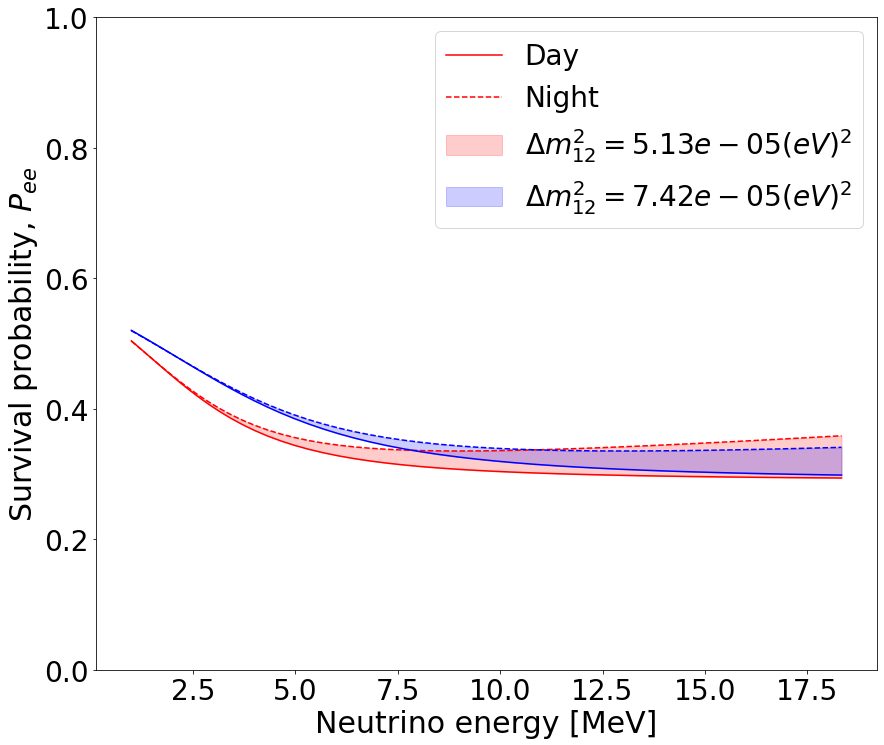

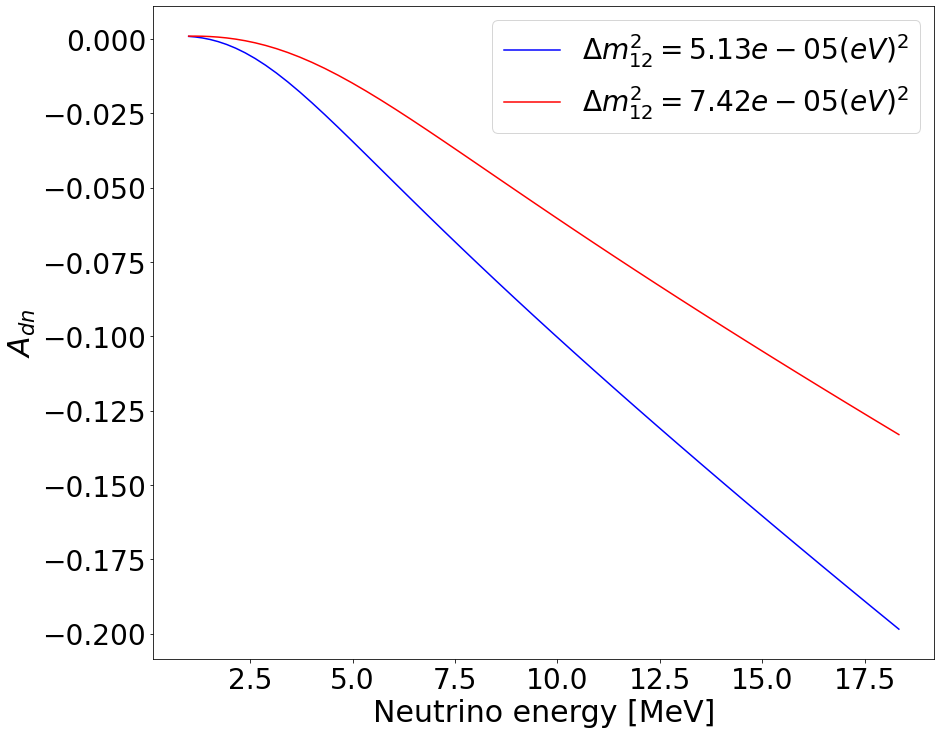

Asymmetry at peak energy: (array([0.35542872]), array([0.36518547]), array([-0.02707897]))


In [6]:
def asym(E, md12): # input energy peak and mass-squared diff 21
    
    E = E*1e6 # energy peak of sensitivity curve, assuming asymmetric distribution
    degrad = math.pi/180 # deg.s to rad.s conversion factor
    Gf =  8.958e-44  #eV m3, Fermi constant
    
    ######################################
    # solar input parameters
    
    cMSW = 1 # divergence from msw theory
    peS = 92.5e3/1.673e-27 # m-3, e density of Sun at B8 production point 
    peE = 2.8e3/1.673e-27 # m-3, average e density of Earth 
    # add eccentricity (https://arxiv.org/abs/1506.08158)

    ######################################
    # oscillation parameters:

    #md12 = 7.42e-5 #eV^2, mass-square diff. 
    md13 = 2.515e-3 #eV^2
    
    a12 = 33.4*degrad   # rad, mixing angle
    a13 = 8.57*degrad
    
    s13 = math.sin(a13)
    c13 = math.cos(a13)
    
    s12 = math.sin(a12)
    c12 = math.cos(a12)
    
    s2a12 = math.sin(2*a12)
    c2a12 = math.cos(2*a12)
    
    ######################################
    
    lrS = ((2*2**0.5)*Gf*cMSW*peS*E*(c13**2))/md12 # ratio of oscillation length and refraction length in Sun
    lrE = ((2*2**0.5)*Gf*cMSW*peE*E*(c13**2))/md12 # " " in Earth
    
    c2a12S = (c2a12 - lrS)/(1 - 2*lrS*c2a12 + lrS**2)**0.5 # mixing angle in Sun matter
    c2a12E = (c2a12 - lrE)/(1 - 2*lrE*c2a12 + lrE**2)**0.5 # " " in Earth
    
    s2a12E = np.sin(np.arccos(c2a12E))
    
    freg = 0.5*(c13**2)*lrE*(s2a12E**2) # regenerative factor
    
    pd = (c13**4)*(0.5 + 0.5*c2a12S*c2a12) + s13**4
    pn = pd - c2a12S*(c13**2)*freg
    
    asym = (2*c2a12S*(c13**2)*freg)/(2*pd - c2a12S*(c13**2)*freg)

    return pd, pn, asym

plt.figure(figsize=(14,12))

Spd, Spn, Sasym = asym(xdata, Smd12) # solar day/night surv prob.
Rpd, Rpn, Rasym = asym(xdata, Rmd12) # reactor " "

plt.plot(xdata, Spd, color="red", label=r'Day')
plt.plot(xdata, Spn, color="red", linestyle='dashed', label=r'Night')
plt.fill_between(xdata, Spd, Spn, color='red', alpha=0.2, label=r'$\Delta m_{12}^2 =' + repr(Smd12) + '(eV)^2$')

plt.plot(xdata, Rpd, color="blue")
plt.plot(xdata, Rpn, color="blue", linestyle='dashed')
plt.fill_between(xdata, Rpd, Rpn, color='blue', alpha=0.2, label=r'$\Delta m_{12}^2 =' + repr(Rmd12) + '(eV)^2$')

#plt.xscale('log')
#plt.yscale('log')

plt.xlabel('Neutrino energy [MeV]',fontsize=30)
plt.xticks(fontsize=28)
plt.ylabel(r'Survival probability, $P_{ee}$',fontsize=30)
plt.yticks(fontsize=28)
plt.ylim(0,1)

plt.legend(fontsize=28)

plt.show()

##########################################

plt.figure(figsize=(14,12))

plt.plot(xdata, Sasym, color="blue", label=r'$\Delta m_{12}^2 =' + repr(Smd12) + '(eV)^2$')
plt.plot(xdata, Rasym, color="red", label=r'$\Delta m_{12}^2 =' + repr(Rmd12) + '(eV)^2$')

plt.xlabel('Neutrino energy [MeV]',fontsize=30)
plt.xticks(fontsize=28)
plt.ylabel(r'$A_{dn~}$',fontsize=30)
plt.yticks(fontsize=28)

plt.legend(fontsize=28)

plt.show()

print('Asymmetry at peak energy:', asym(xdata[fluxspec == np.max(fluxspec)], Rmd12))

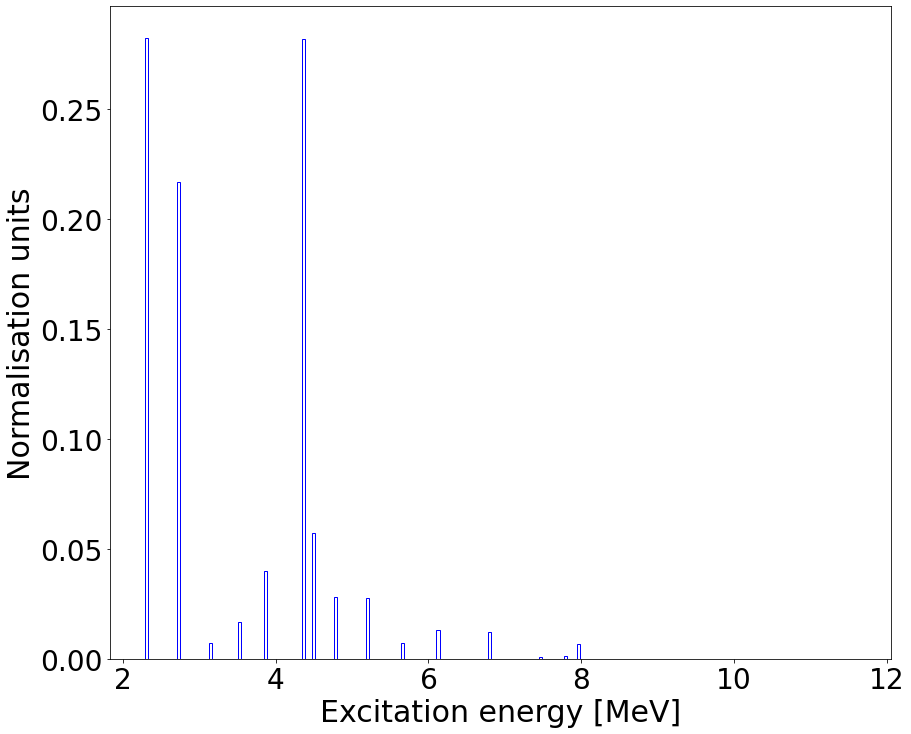

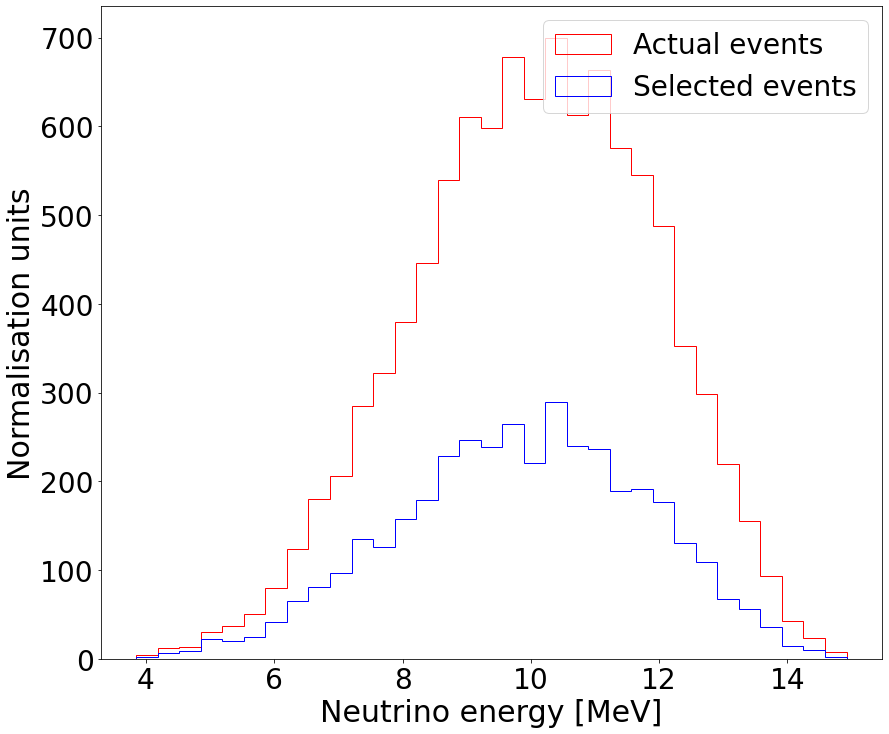

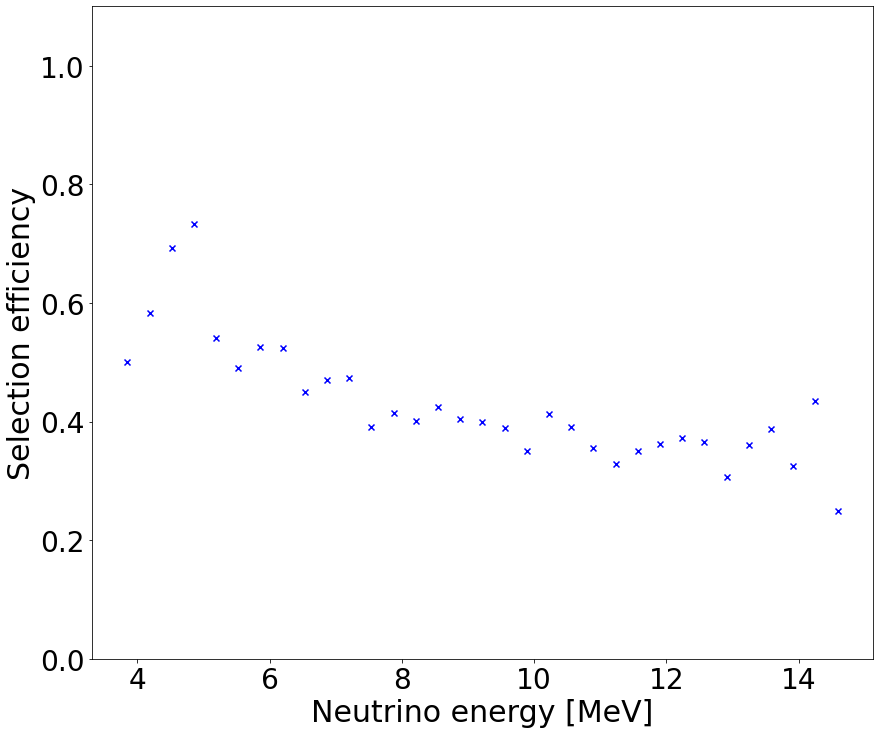

Mean selection efficiency: 0.3744310853150673


In [28]:
def optim_bins(mult_arry):
    # optimises bin widths based on Freedman rule of thumb, takes multidimensional array
    
    width_arry = np.array([])
    
    for arry in mult_arry: 
        width_temp = astropy.stats.freedman_bin_width(arry, return_bins=False)
        width_arry = np.append(width_arry, width_temp)
    
    energy_res = np.max(width_arry)
    flat_arry = np.concatenate(mult_arry, axis=0)
    
    return int(round((np.max(flat_arry) - np.min(flat_arry)) / energy_res, 0))

def hist_weights(rates, data):
    # returns weights of normalised histogram
    
    weights = []
    i = 0

    for event in data:
        weight = (rates[i]*np.ones_like(event))/len(event) #fraction = expected events / num of events generated
        weights.append(weight)
        i += 1
    
    return weights

def root_input(filename):
    # takes marsum configured MARLEY input file 
    
    rTree = uproot.open(filename)
    
    rTree_event = rTree['mst']
    Ex = np.array(rTree_event['Ex'])
    Ev = np.array(rTree_event['Ev'])
    KEl = np.array(rTree_event['KEl'])
    pdgp = np.array(rTree_event['pdgp'])
    Ep = np.array(rTree_event['Ep'])
    xsec = np.array(rTree_event['xsec'])
    
    return Ex, Ev, KEl, pdgp, Ep, xsec

filename = 'bahcallB8marley.root'
Ex, Ev, KEl, pdgp, Ep, xsec = root_input(filename)

#####################################

plt.figure(figsize=(14,12))

data = [Ex]
rates = [1]

n, bins, patches = plt.hist(data, weights=hist_weights(rates,data), histtype='step', color='blue', bins=optim_bins(data), alpha=1)

plt.xlabel('Excitation energy [MeV]',fontsize=30)
plt.xticks(fontsize=28)
plt.ylabel('Normalisation units',fontsize=30)
plt.yticks(fontsize=28)
#plt.yscale('log')

plt.show()

###################################

numevents = 10000
data = np.concatenate([Ep[0:numevents]])

#prompt = np.array([])
selecEv = np.array([])

i = 0
for array in data:
    
    if any(1.6 < x < 1.616 for x in array):
        #prompt = np.append(prompt, KEl[i] + (np.sum(array)-1.614-0.03))
        selecEv = np.append(selecEv, Ev[i])

    i += 1
    
plt.figure(figsize=(14,12))

data = [selecEv, Ev[0:numevents]]
labels = ['Selected events', 'Actual events']

n, bins, patches = plt.hist(data, histtype='step', color=['blue', 'red'], label=labels, bins=optim_bins(data), alpha=1)

plt.xlabel('Neutrino energy [MeV]',fontsize=30)
plt.xticks(fontsize=28)
plt.ylabel('Normalisation units',fontsize=30)
plt.yticks(fontsize=28)
#plt.yscale('log')

plt.legend(fontsize=28)

plt.show()

#################################

plt.figure(figsize=(14,12))

seleceff = n[0]/n[1]
bins = bins[0:len(seleceff)]

plt.scatter(bins, seleceff, color="blue", marker='x')

plt.xlabel('Neutrino energy [MeV]',fontsize=30)
plt.xticks(fontsize=28)
plt.ylabel('Selection efficiency',fontsize=30)
plt.yticks(fontsize=28)
#plt.yscale('log')

plt.ylim(0,1.1)
#plt.legend(fontsize=28)

plt.show()

mseleceff = np.mean(seleceff[(bins > 8) & (bins < 13)])
print('Mean selection efficiency:', mseleceff)


Probabaility of detection: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.00006783 0.00072144 0.00205168 0.00448917 0.00781675 0.01234827
 0.01866625 0.02812775 0.04177166 0.05752136 0.07704864 0.09855363
 0.12192661 0.14540932 0.16715588 0.18466422 0.1956875  0.19797316
 0.19121613 0.17460857 0.14723863 0.11098481 0.0726583  0.03759367
 0.01348674 0.00316251 0.00047186 0.00002655 0.         0.
 0.         0.        ]
Energy bins: [ 0.925       1.075       1.24932432  1.42890271  1.62008337  1.82284483
  2.03716811  2.26303638  2.50043454  2.74934898  3.0097674   3.28167858
  3.56507225  3.85993902  4.1662702   4.48405779  4.81329434  5.15397294
  5.50608715  5.86963096  6.2445987   6.63098511  7.02878518  7.43799424
  7.85860785  8.29062183  8.73403221  9.18883523  9.65502733 10.1326051
 10.62156531 11.12190489 11.6336209  12.15671052 12.69117107 13.23699998
 13.79419478 14.36275311 14.94267271 15.5339514  16.13

/tmp/ipykernel_33807/789320670.py:9: RuntimeWarning: invalid value encountered in true_divide
  crosssec = (n*numflux*np.mean(xsec))/fluxspec # calculate cross section used in MARLEY


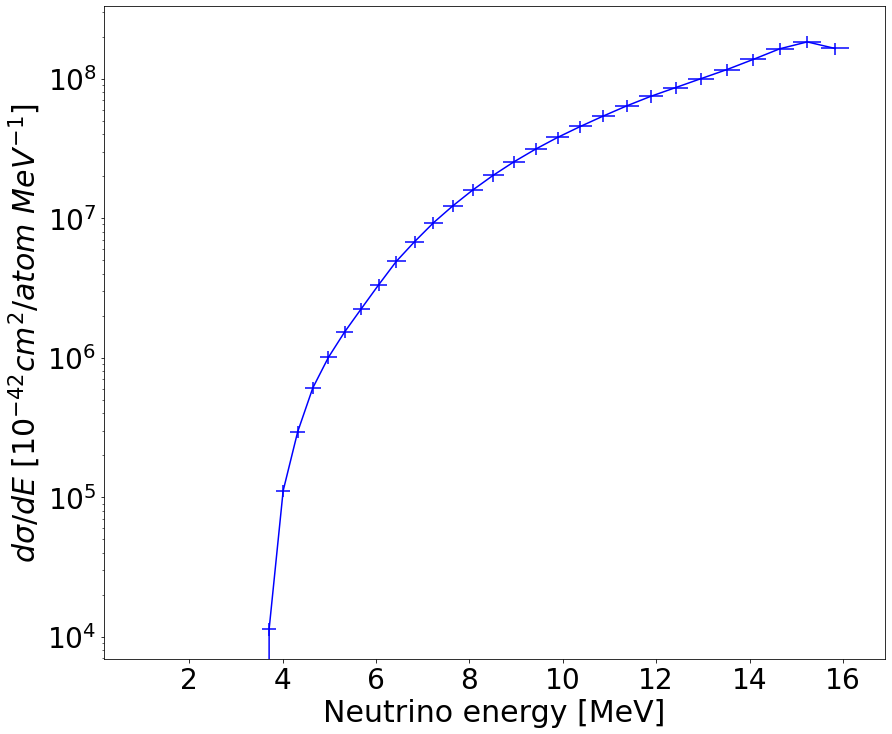

In [21]:
plt.figure(figsize=(14,12))

n, edges = np.histogram(Ev, edges, density=True) # bin edges taken

print('Probabaility of detection:', n)
print('Energy bins:', edges)
print('Flux averaged total cross section:', np.mean(xsec))

crosssec = (n*numflux*np.mean(xsec))/fluxspec # calculate cross section used in MARLEY

plt.errorbar(xdata, crosssec, xerr=uncer, yerr=crosssec*cserr, marker='', color="blue", label=r'MARLEY cross section')

plt.xlabel('Neutrino energy [MeV]',fontsize=30)
plt.ylabel('$d\sigma/dE$ [$10^{-42} cm^{2}/atom\ MeV^{-1}$]',fontsize=30)

plt.xticks(fontsize=28)
plt.yticks(fontsize=28)

plt.yscale('log')

plt.show()

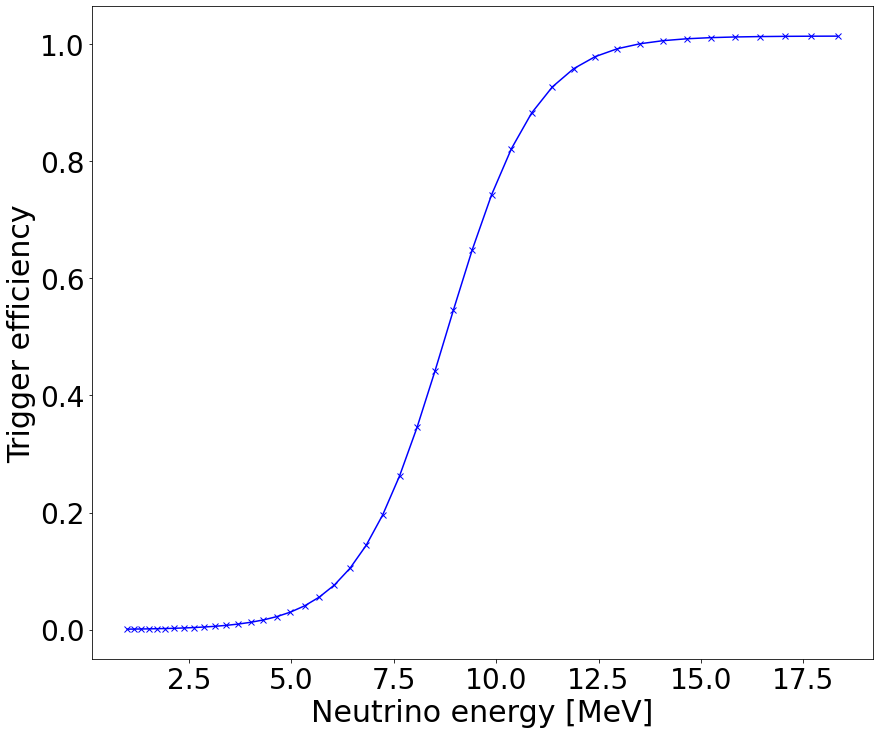

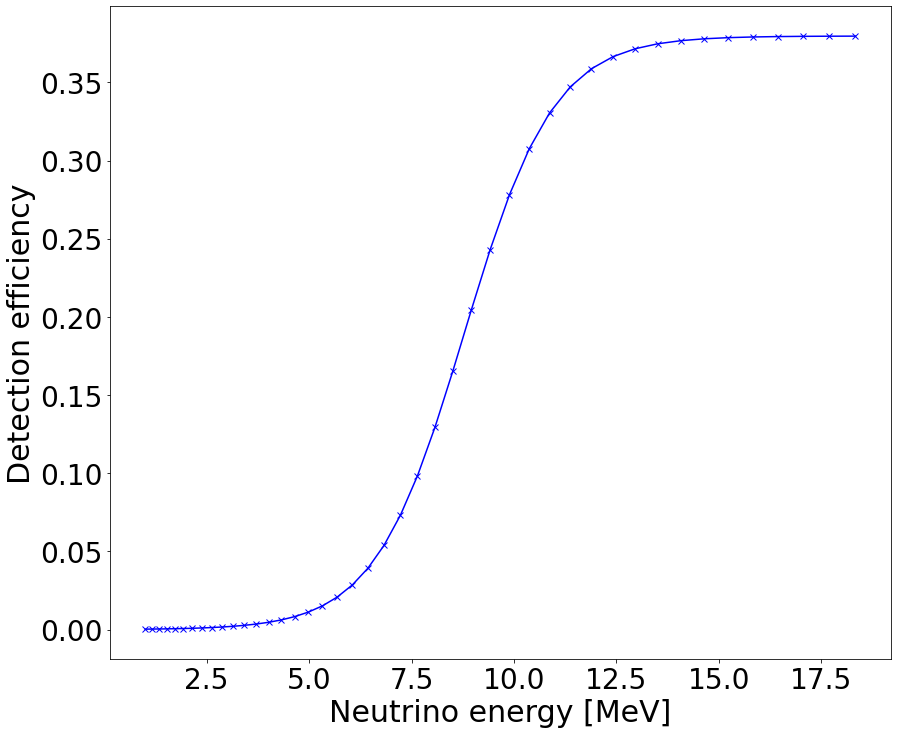

In [32]:
def sigmoid(x, a, b, c):
    return a/(1 + np.exp(-b*x+c))

params = [1.01391104, 0.91687735, 8.06047126]

############################

plt.figure(figsize=(14,12))

plt.plot(xdata, sigmoid(xdata, *params), color='blue', marker='x')

plt.ylabel('Trigger efficiency', fontsize=30)
plt.xlabel(r'Neutrino energy [MeV]', fontsize=30)

plt.xticks(fontsize=28)
plt.yticks(fontsize=28)

plt.show()

###########################

plt.figure(figsize=(14,12))

deteceff = mseleceff*sigmoid(xdata, *params)

plt.plot(xdata, deteceff, color='blue', marker='x')

plt.ylabel('Detection efficiency', fontsize=30)
plt.xlabel(r'Neutrino energy [MeV]', fontsize=30)

plt.xticks(fontsize=28)
plt.yticks(fontsize=28)

plt.show()

/tmp/ipykernel_33807/3240565088.py:17: RuntimeWarning: invalid value encountered in true_divide
  R_var = R**2*((eff_std/eff)**2+(flux_std)**2+(cross_std/crosssec)**2)
/tmp/ipykernel_33807/3240565088.py:17: RuntimeWarning: invalid value encountered in true_divide
  R_var = R**2*((eff_std/eff)**2+(flux_std)**2+(cross_std/crosssec)**2)
/tmp/ipykernel_33807/3240565088.py:17: RuntimeWarning: invalid value encountered in true_divide
  R_var = R**2*((eff_std/eff)**2+(flux_std)**2+(cross_std/crosssec)**2)


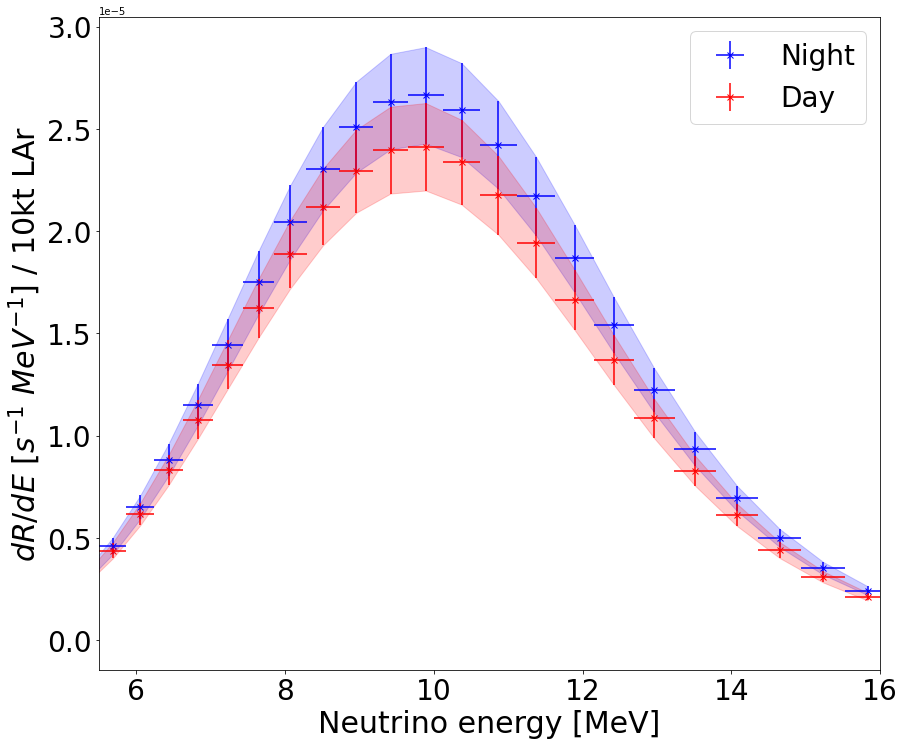

0.00014883883040183173 0.00016400451620643227


In [31]:
plt.figure(figsize=(14,12))

#Gaussian function

def gauss_function(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

def f(x, A, B):
    return A*x + B

def R_errors(R, eff_std, flux_std, cross_perc):
    
    cross_std = (cross_perc/100)*crosssec
    cross_std[np.isnan(cross_std)] = 0
    cross_std[np.isinf(cross_std)] = 0
    
    R_var = R**2*((eff_std/eff)**2+(flux_std)**2+(cross_std/crosssec)**2)
    return np.sqrt(R_var)

resol = inEres
a = np.sqrt(2*np.pi)*resol

sigma = resol
params_lin = [0.99960798, -1.50237267]
eff = sigmoid(x, *params)

nt = 10e31 # number of target atoms in 10kT LAr module
fac = 1e-42 # cross-section factor

intnight_E = np.array([])
intday_E = np.array([])

#totflux = 5.25*10**6  #cm-2s-1, SNO

flux_std = 0.2/5.25
cross_perc = 8 #%
eff_std=0

for i in range(0, len(xdata)):
    
    convener = f(xdata, params_lin[0], params_lin[1])
    convE = f(xdata[i], params_lin[0], params_lin[1])
    
    nightval = eff*nt*fluxspec*crosssec*Spn*gauss_function(convener, a/convE, convE, resol*convE)*fac
    nightval[np.isnan(nightval)] = 0
    intnight_E = np.append(intnight_E, sum(nightval))
    
for i in range(0, len(xdata)):
    
    convener = f(xdata, params_lin[0], params_lin[1])
    convE = f(xdata[i], params_lin[0], params_lin[1])
    
    dayval = eff*nt*fluxspec*crosssec*Spd*gauss_function(convener, a/convE, convE, resol*convE)*fac
    
    dayval[np.isnan(dayval)] = 0
    intday_E = np.append(intday_E, sum(dayval))

plt.errorbar(xdata, intnight_E, xerr=uncer, linestyle='',yerr=R_errors(intnight_E, eff_std, flux_std, cross_perc), marker="x", color="blue", label='Night')
plt.errorbar(xdata, intday_E, xerr=uncer, linestyle='',yerr=R_errors(intday_E, eff_std, flux_std, cross_perc), marker="x", color="red", label='Day')

plt.fill_between(xdata, (intnight_E)+R_errors(intnight_E, eff_std, flux_std, cross_perc), (intnight_E)-R_errors(intnight_E, eff_std, flux_std, cross_perc), color='blue', alpha=0.2)
plt.fill_between(xdata, (intday_E)+R_errors(intday_E, eff_std, flux_std, cross_perc), (intday_E)-R_errors(intday_E, eff_std, flux_std, cross_perc), color='red', alpha=0.2)

plt.xlabel('Neutrino energy [MeV]',fontsize=30)
plt.xticks(fontsize=28)

plt.ylabel('$dR/dE$ [$s^{-1}\ MeV^{-1}$] / $10$kt LAr',fontsize=30)
plt.yticks(fontsize=28)
plt.legend(fontsize=28)

plt.xlim(5.5,16)

#plt.ylim(0, 1500)
#plt.title("SNOwGLoBES", fontsize=20)
plt.show()

rateday = np.sum(intday_E*bwidth)
ratenight = np.sum(intnight_E*bwidth)
print(rateday, ratenight)

In [33]:
def asymerr(night, day, back):
    #print(night, day)
    
    tempasymmetry = 2*(night-day)/(night+day+2*back)
    #tempuncer = np.sqrt(((2*((2*day + 2*back)/(night + day + 2*back)))**2)*((1/np.sqrt(night))**2) + 
    #                ((2*((2*night + 2*back)/(day + night + 2*back)))**2)*((1/np.sqrt(day))**2) +
    #                ((2*((2*(night - day))/(night + day + 2*back)**2))**2)*((1/np.sqrt(back))**2)) 
    
    tempuncer = np.sqrt((4*(day+back)/(night+day+back)**2)**2*(day) + (4*(night+back)/(night+day+back)**2)**2*(night) 
                        +(4*(night-day)/(night+day+back)**2)**2*(back))
    
    sumasym = np.sum((tempasymmetry/tempuncer**2)[~np.isnan(tempasymmetry/tempuncer**2)])
    sumuncer = np.sum((1/tempuncer**2)[~np.isinf(1/tempuncer**2)])
    
    asymoutput = (sumasym/sumuncer)
    uncerstat = np.sqrt(1/sumuncer)
    
    uncersys = 0.1
    
    unceroutput = np.sqrt((uncerstat/asymoutput)**2 + uncersys**2)
    
    return asymoutput*100, asymoutput*unceroutput*100, tempasymmetry, tempuncer

back = 1e0

#expo_time = np.linspace(1, 20, 19)

years = 5
expo = years*3.14e7*4

#asym_array = np.array([])
#uncer_array = np.array([])

#for i in range(0, len(expo_time)):
#    asym_a, uncer_a, asymarray_a, uncerarray_a = asymerr(ratenight*expo_time[i]*3.14e7, rateday*expo_time[i]*3.14e7, back)
#    asym_array = np.append(asym_array, asym_a)
#    uncer_array = np.append(uncer_array, uncer_a)

asymfin, uncerfin, asymarray, uncerarray = asymerr(ratenight*expo, rateday*expo, back)

print("Night-day asymmetry:", asymfin, "+/-", uncerfin, "%")
print(rateday, ratenight)
#print(rateday*expo)

#print(osc(10, 5.13e-5))
#print(asym_array)

Night-day asymmetry: 9.695287808071344 +/- 1.070055784400341 %
0.00014883883040183173 0.00016400451620643227


In [35]:
def measasym(years, vol):
    
    resol = inEres
    a = np.sqrt(2*np.pi)*resol

    sigma = resol
    params_lin = [0.99960798, -1.50237267]
    eff = sigmoid(x, *params)

    nt = vol*10e31 # number of target atoms in 10kT LAr module
    fac = 1e-42 # cross-section factor

    intnight_E = np.array([])
    intday_E = np.array([])

    #totflux = 5.25*10**6  #cm-2s-1, SNO

    flux_std = 0.2/5.25
    cross_perc = 8 #%
    eff_std=0

    for i in range(0, len(xdata)):
    
        convener = f(xdata, params_lin[0], params_lin[1])
        convE = f(xdata[i], params_lin[0], params_lin[1])
    
        nightval = eff*nt*fluxspec*crosssec*pn1*gauss_function(convener, a/convE, convE, resol*convE)*fac
        nightval[np.isnan(nightval)] = 0
        intnight_E = np.append(intnight_E, sum(nightval))
    
    for i in range(0, len(xdata)):
    
        convener = f(xdata, params_lin[0], params_lin[1])
        convE = f(xdata[i], params_lin[0], params_lin[1])
    
        dayval = eff*nt*fluxspec*crosssec*pd1*gauss_function(convener, a/convE, convE, resol*convE)*fac
    
        dayval[np.isnan(dayval)] = 0
        intday_E = np.append(intday_E, sum(dayval))

    upbndn = np.sum((intnight_E + R_errors(intnight_E, eff_std, flux_std, 
            cross_perc)*bwidth)[~np.isnan((intnight_E + R_errors(intnight_E, eff_std, flux_std, cross_perc)))]) 
    lowbndn = np.sum((intnight_E - R_errors(intnight_E, eff_std, flux_std, 
            cross_perc)*bwidth)[~np.isnan((intnight_E - R_errors(intnight_E, eff_std, flux_std, cross_perc)))])
    
    upbndd = np.sum((intday_E + R_errors(intday_E, eff_std, flux_std, 
            cross_perc)*bwidth)[~np.isnan((intday_E + R_errors(intday_E, eff_std, flux_std, cross_perc)))])
    lowbndd = np.sum((intday_E - R_errors(intday_E, eff_std, flux_std, 
            cross_perc)*bwidth)[~np.isnan((intday_E - R_errors(intday_E, eff_std, flux_std, cross_perc)))])
    
    rateday = np.sum(intday_E*bwidth)
    ratenight = np.sum(intnight_E*bwidth)
    
    
    expo = years*3.14e7

    asym, uncer, asymarray, uncerarray = asymerr(ratenight*expo, rateday*expo, back)
    asymup, uncerup, asymarrayup, uncerarrayup = asymerr(upbndn*expo, upbndd*expo, back)
    asymlow, uncerlow, asymarraylow, uncerarraylow = asymerr(lowbndn*expo, lowbndd*expo, back)
    
    asymexp = -asm(9.75e6, 7.42e-5)*100
    
    return ((asym-asymexp)**2/uncer**2)**0.5, ((asymup-asymexp)**2/uncerup**2)**0.5, ((asymlow-asymexp)**2/uncerlow**2)**0.5, asym, uncer

yarray = np.arange(0.01, 30, 0.01)
sarray = np.array([])
sarrayup = np.array([])
sarraylow = np.array([])

for elem in yarray:
    temp = asym(elem, 1)
    
    sarray = np.append(sarray, temp[0])
    sarrayup = np.append(sarrayup, temp[1])
    sarraylow = np.append(sarraylow, temp[2])
    
sarray40 = np.array([])
sarrayup40 = np.array([])
sarraylow40 = np.array([])

for elem in yarray:
    temp = asym(elem, 4)
    
    sarray40 = np.append(sarray40, temp[0])
    sarrayup40 = np.append(sarrayup40, temp[1])
    sarraylow40 = np.append(sarraylow40, temp[2])
    
sarray70 = np.array([])
sarrayup70 = np.array([])
sarraylow70 = np.array([])

for elem in yarray:
    temp = asym(elem, 7)
    
    sarray70 = np.append(sarray70, temp[0])
    sarrayup70 = np.append(sarrayup70, temp[1])
    sarraylow70 = np.append(sarraylow70, temp[2])
    

NameError: name 'pn1' is not defined

In [ ]:
def chisquar(obs, uncer, exp):
    
    chisquar = ((obs - exp)**2)/uncer**2
    
    return chisquar

#KL = [7.54e-5, 0.18e-5] # measurement and error
#asymDUNE = [osc(5.13e-5), osc(5.13e-5)*0.15]
globsolar = [5.13e-5, 1.25e-5]

#chiKL = chisquar(KL[0], KL[1], x)
#chiDUNE = chisquar(asymDUNE[0], asymDUNE[1], osc(x))
chiGS = chisquar(globsolar[0], globsolar[1], 7.54e-5) # global solar

y = chiGS**0.5


plt.figure(figsize=(14,12))

plt.plot(yarray, sarrayup70+y, color='green', marker='x', markersize=0, label='$70$kt LAr')
plt.plot(yarray, sarraylow70+y, color='green', marker='x', markersize=0)

plt.fill_between(yarray, sarraylow70+y, sarrayup70+y, color='green', alpha=0.2)

#########################

plt.plot(yarray, sarrayup40+y, color='red', marker='x', markersize=0, label='$40$kt LAr')
plt.plot(yarray, sarraylow40+y, color='red', marker='x', markersize=0)

plt.fill_between(yarray, sarraylow40+y, sarrayup40+y, color='red', alpha=0.2)

########################

#plt.plot(yarray, sarray, color='blue', marker='x')
plt.plot(yarray, sarrayup+y, color='blue', marker='x', markersize=0, label='$10$kt LAr')
plt.plot(yarray, sarraylow+y, color='blue', marker='x', markersize=0)

plt.fill_between(yarray, sarraylow+y, sarrayup+y, color='blue', alpha=0.2)

plt.ylabel(r'$\sigma = \sqrt{\Delta \chi^2}$', fontsize=30)
plt.xlabel(r'Exposure [years]', fontsize=30)

plt.xticks(fontsize=28)
plt.yticks(fontsize=28)

plt.axhline(y=3, color='black', linestyle='--', linewidth=0.7)
plt.axhline(y=5, color='black', linestyle='--', linewidth=0.7)

plt.xlim(0,10)
plt.ylim(1.8,4.8)

#plt.yscale('log')

plt.legend(fontsize=28)
plt.show()



In [ ]:
def asym(years, vol):
    
    resol = inEres
    a = np.sqrt(2*np.pi)*resol

    sigma = resol
    params_lin = [0.99960798, -1.50237267]
    eff = sigmoid(x, *params)

    nt = vol*10e31 # number of target atoms in 10kT LAr module
    fac = 1e-42 # cross-section factor

    intnight_E = np.array([])
    intday_E = np.array([])

    #totflux = 5.25*10**6  #cm-2s-1, SNO

    flux_std = 0.2/5.25
    cross_perc = 8 #%
    eff_std=0

    for i in range(0, len(xdata)):
    
        convener = f(xdata, params_lin[0], params_lin[1])
        convE = f(xdata[i], params_lin[0], params_lin[1])
    
        nightval = eff*nt*fluxspec*crosssec*pn1*gauss_function(convener, a/convE, convE, resol*convE)*fac
        nightval[np.isnan(nightval)] = 0
        intnight_E = np.append(intnight_E, sum(nightval))
    
    for i in range(0, len(xdata)):
    
        convener = f(xdata, params_lin[0], params_lin[1])
        convE = f(xdata[i], params_lin[0], params_lin[1])
    
        dayval = eff*nt*fluxspec*crosssec*pd1*gauss_function(convener, a/convE, convE, resol*convE)*fac
    
        dayval[np.isnan(dayval)] = 0
        intday_E = np.append(intday_E, sum(dayval))

    upbndn = np.sum((intnight_E + R_errors(intnight_E, eff_std, flux_std, 
            cross_perc)*bwidth)[~np.isnan((intnight_E + R_errors(intnight_E, eff_std, flux_std, cross_perc)))]) 
    lowbndn = np.sum((intnight_E - R_errors(intnight_E, eff_std, flux_std, 
            cross_perc)*bwidth)[~np.isnan((intnight_E - R_errors(intnight_E, eff_std, flux_std, cross_perc)))])
    
    upbndd = np.sum((intday_E + R_errors(intday_E, eff_std, flux_std, 
            cross_perc)*bwidth)[~np.isnan((intday_E + R_errors(intday_E, eff_std, flux_std, cross_perc)))])
    lowbndd = np.sum((intday_E - R_errors(intday_E, eff_std, flux_std, 
            cross_perc)*bwidth)[~np.isnan((intday_E - R_errors(intday_E, eff_std, flux_std, cross_perc)))])
    
    rateday = np.sum(intday_E*bwidth)
    ratenight = np.sum(intnight_E*bwidth)
    
    
    expo = years*3.14e7

    asym, uncer, asymarray, uncerarray = asymerr(ratenight*expo, rateday*expo, back)
    asymup, uncerup, asymarrayup, uncerarrayup = asymerr(upbndn*expo, upbndd*expo, back)
    asymlow, uncerlow, asymarraylow, uncerarraylow = asymerr(lowbndn*expo, lowbndd*expo, back)
    
    asymexp = 0
    
    return ((asym-asymexp)**2/uncer**2)**0.5, ((asymup-asymexp)**2/uncerup**2)**0.5, ((asymlow-asymexp)**2/uncerlow**2)**0.5, asym, uncer

yarray = np.arange(0.01, 30, 0.01)
sarray = np.array([])
sarrayup = np.array([])
sarraylow = np.array([])

for elem in yarray:
    temp = asym(elem, 1)
    
    sarray = np.append(sarray, temp[0])
    sarrayup = np.append(sarrayup, temp[1])
    sarraylow = np.append(sarraylow, temp[2])
    
sarray40 = np.array([])
sarrayup40 = np.array([])
sarraylow40 = np.array([])

for elem in yarray:
    temp = asym(elem, 4)
    
    sarray40 = np.append(sarray40, temp[0])
    sarrayup40 = np.append(sarrayup40, temp[1])
    sarraylow40 = np.append(sarraylow40, temp[2])
    
sarray70 = np.array([])
sarrayup70 = np.array([])
sarraylow70 = np.array([])

for elem in yarray:
    temp = asym(elem, 7)
    
    sarray70 = np.append(sarray70, temp[0])
    sarrayup70 = np.append(sarrayup70, temp[1])
    sarraylow70 = np.append(sarraylow70, temp[2])
    



In [ ]:

plt.figure(figsize=(14,12))

plt.plot(yarray, sarrayup70, color='green', marker='x', markersize=0, label='$70$kt LAr')
plt.plot(yarray, sarraylow70, color='green', marker='x', markersize=0)

plt.fill_between(yarray, sarraylow70, sarrayup70, color='green', alpha=0.2)

#########################

plt.plot(yarray, sarrayup40, color='red', marker='x', markersize=0, label='$40$kt LAr')
plt.plot(yarray, sarraylow40, color='red', marker='x', markersize=0)

plt.fill_between(yarray, sarraylow40, sarrayup40, color='red', alpha=0.2)

########################

#plt.plot(yarray, sarray, color='blue', marker='x')
plt.plot(yarray, sarrayup, color='blue', marker='x', markersize=0, label='$10$kt LAr')
plt.plot(yarray, sarraylow, color='blue', marker='x', markersize=0)

plt.fill_between(yarray, sarraylow, sarrayup, color='blue', alpha=0.2)

plt.ylabel(r'$\sigma = \sqrt{\Delta \chi^2}$', fontsize=30)
plt.xlabel(r'Exposure [years]', fontsize=30)

plt.xticks(fontsize=28)
plt.yticks(fontsize=28)

plt.axhline(y=3, color='black', linestyle='--', linewidth=0.7)
plt.axhline(y=5, color='black', linestyle='--', linewidth=0.7)

plt.xlim(0,8)
plt.ylim(0,8)

#plt.yscale('log')

plt.legend(fontsize=28)
plt.show()